# Solid spherical charge

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from libemag.emag_initials import *
from libemag.plots import field_plot
import sympy as smp
from scipy.integrate import tplquad
from joblib import Parallel, delayed
from scipy import integrate
import warnings

In [2]:
x, y, z = smp.symbols('x, y, z', real=True)
r, theta, phi = smp.symbols('r, theta, phi', real=True, positive=True)

rv = smp.Matrix([x, y, z])
rp = smp.Matrix([r * smp.sin(theta) * smp.cos(phi),\
                r * smp.sin(theta) * smp.sin(phi),\
                r * smp.cos(theta)])
R = rv - rp
R

Matrix([
[-r*sin(theta)*cos(phi) + x],
[-r*sin(phi)*sin(theta) + y],
[         -r*cos(theta) + z]])

In [3]:
a = 1.
Q = 1e-9

dqdv = r**2 * smp.Abs(smp.sin(theta))

dEdv = dqdv * R / R.norm()**3
dEdv

Matrix([
[r**2*(-r*sin(theta)*cos(phi) + x)*Abs(sin(theta))/((r*cos(theta) - z)**2 + (r*sin(phi)*sin(theta) - y)**2 + (r*sin(theta)*cos(phi) - x)**2)**(3/2)],
[r**2*(-r*sin(phi)*sin(theta) + y)*Abs(sin(theta))/((r*cos(theta) - z)**2 + (r*sin(phi)*sin(theta) - y)**2 + (r*sin(theta)*cos(phi) - x)**2)**(3/2)],
[         r**2*(-r*cos(theta) + z)*Abs(sin(theta))/((r*cos(theta) - z)**2 + (r*sin(phi)*sin(theta) - y)**2 + (r*sin(theta)*cos(phi) - x)**2)**(3/2)]])

In [7]:
integrand_x = smp.lambdify([r, theta, phi, x, y, z], dEdv[0])
integrand_y = smp.lambdify([r, theta, phi, x, y, z], dEdv[1])
integrand_z = smp.lambdify([r, theta, phi, x, y, z], dEdv[2])

integrand_x(1., 1.5, 1.5, 1, 1, 1)

0.4083548976261469

In [8]:
%%time
def E(x, y, z):
    # Suppress IntegrationWarning
    warnings.filterwarnings("ignore", category=integrate.IntegrationWarning)
    Ex = tplquad(integrand_x, 0., 2. * pi, 0., pi, 0., a, args=(x, y, z))[0]
    Ey = tplquad(integrand_y, 0., 2. * pi, 0., pi, 0., a, args=(x, y, z))[0]
    Ez = tplquad(integrand_z, 0., 2. * pi, 0., pi, 0., a, args=(x, y, z))[0]
    
    return np.array([Ex, Ey, Ez])

np.linalg.norm(E(1., 1., 1.))

CPU times: user 3.53 s, sys: 3.7 ms, total: 3.53 s
Wall time: 3.53 s


1.396263401595458

In [9]:
%%time
# Parallel Processing
from joblib import Parallel, delayed
X = np.linspace(-10., 10., 200)

# Function to vectorize
def compute_E_field(x, y, z):
    result = E(x, y, z)
    mag = np.linalg.norm(result)
    print(f'At x = {x}, E_field is {mag}')
    return mag

E_field = Parallel(n_jobs=-1)(delayed(compute_E_field)(x, 0., 0.) for x in X)

CPU times: user 9 s, sys: 168 ms, total: 9.17 s
Wall time: 1min 38s


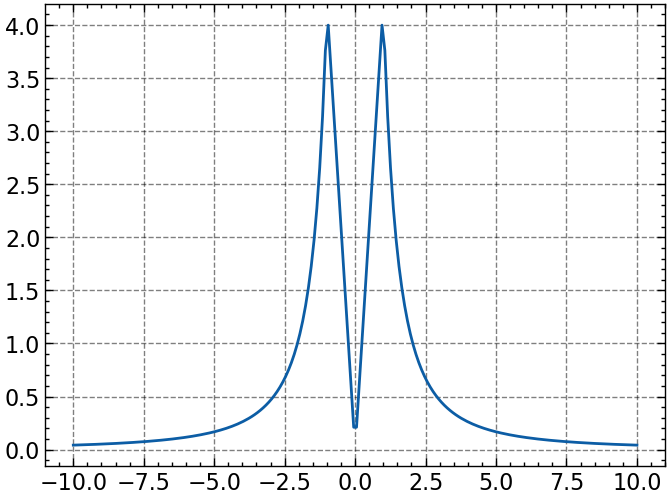

In [10]:
# Plot
plt.plot(X, E_field)

In [31]:
a = 1.0
def E(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    if r < a:
        Ex = (x / a**3)
        Ey = (y / a**3)
        Ez = (z / a**3)
    else:
        Ex = (x / r**3)
        Ey = (y / r**3)
        Ez = (z / r**3)
    return np.array([Ex, Ey, Ez])

E(1, 1, 1)

array([0.19245009, 0.19245009, 0.19245009])

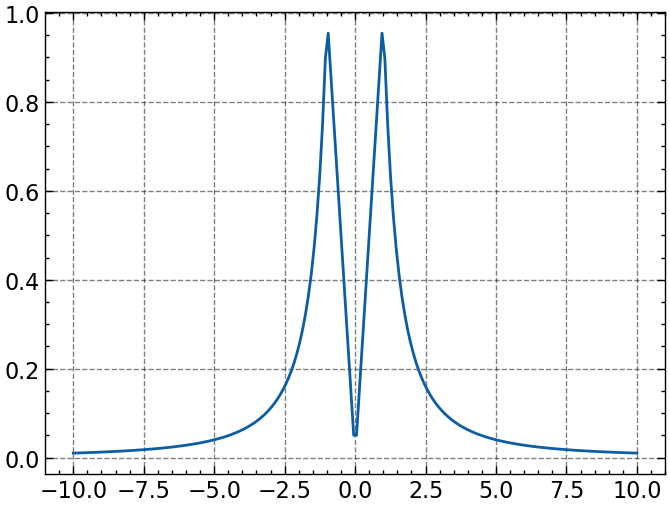

In [32]:
X = np.linspace(-10., 10., 200)
E_field = np.array([np.linalg.norm(E(x, 0, 0)) for x in X])
plt.plot(X, E_field)

In [33]:
def E2D(x, y):
    return E(x, y, 0.)[:2]

<Axes: xlabel='x', ylabel='y'>

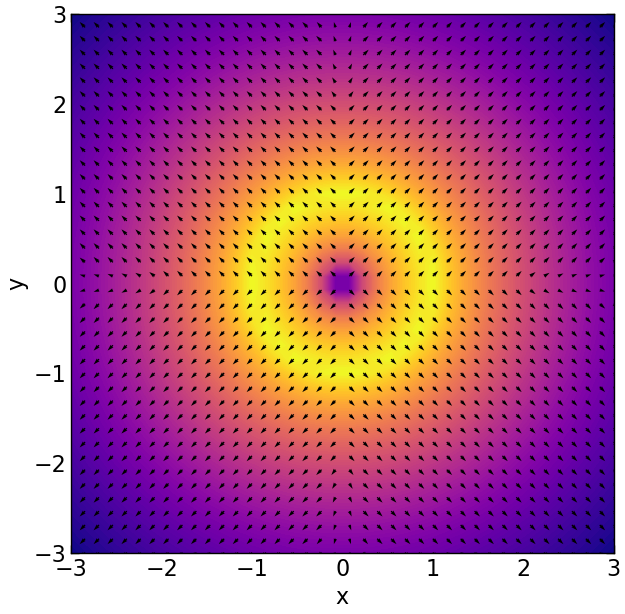

In [37]:
fig = plt.figure(figsize=(7, 7))
field_plot(E2D, x_min=-3, x_max=3, y_min=-3, y_max=3, num_grids=40, contour=True)